# Smallholder Forestry Example 
Requesting Planet's Carbon Monitoring dataset for small plots  

This notebook assumes that you have already registered and installed Cecil in your local environment.  The steps for doing this are located on [Cecil's Getting Started Page](https://docs.cecil.earth/Getting-started-111ef16bbbe48123aaa1d0a4bbd0a63d).

In [2]:
import pandas as pd
import geopandas as gpd

import plotly.express as px

import cecil


In [3]:
# Forest Carbon Monitoring
# https://docs.cecil.earth/Forest-carbon-monitoring-111ef16bbbe4817aa1a8dce6d9216665
# 3.5 m resolution
PLANET_DATASET_ID = '4d8bd6ba-b751-4c46-8e70-5000e6d8b212'
# Cost information for all datasets is available on Cecil's Pricing page
# https://docs.cecil.earth/Pricing-cf107b09599d4638b8f02fc863bd5961
PLANET_COST_PER_HA = 0.25  # USD

# Choose an Area of Interest

Each polygon's area in hectares and number of vertices


,polygon_id,area_ha,vertices
0,0,8.015337,657
1,1,0.472040,85
2,2,0.566890,89
3,3,1.763921,274
4,4,1.249553,170


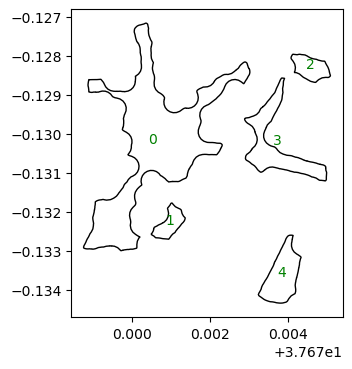

In [38]:
polygons = gpd.read_file('data/intermediate/example_polygons.gpkg', layer='example_polygons')

# Project to UTM zone 37N for accurate area calculation (e.g., UTM zone 37N for Kenya)
polygons_utm = polygons.to_crs(epsg=32637)

# Calculate total area in hectares
total_area_m2 = polygons_utm.geometry.area.sum()

# Calculate number of vertices for each polygon
# Note: This assumes polygons are valid and have an exterior ring
polygons['vertices'] = polygons.geometry.apply(lambda geom: len(geom.exterior.coords) if geom.is_valid else 0)
# Calculate total number of vertices
total_vertices = polygons['vertices'].sum()

# Use the UTM projection to calculate area in hectares
polygons['area_ha'] = polygons_utm.geometry.area / 10000 # 1 hectare = 10,000 m²
total_area_ha = polygons['area_ha'].sum()

#Create a polygon_id column for easier reference
polygons['polygon_id'] = polygons.index.astype('category')
# Change the polygon_id to be a categorical type
# polygons['polygon_id'] = polygons['polygon_id'].astype('category')
# polygons = polygons.reset_index().rename(columns={'index': 'polygon_id'})

print("Each polygon's area in hectares and number of vertices")
display(polygons[['polygon_id', 'area_ha', 'vertices']])

ax = polygons.plot(figsize=(4,4), edgecolor='black', facecolor='none')
for idx, row in polygons.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(str(idx), xy=(centroid.x, centroid.y), color='green', fontsize=10, ha='center')

# Check vertices count and calculate cost of request
AOI requests through Cecil for the Planet Monitoring Dataset should meet the following requirements:
* The CRS is EPSG:4326
* The total number of vertices per AOI is less than 1,500

The pricing for data requests can be found on [Cecil's Pricing page](https://docs.cecil.earth/Pricing-cf107b09599d4638b8f02fc863bd5961).

In this case, "Planet Forest Carbon Monitoring 3m" is $0.25/ha.



In [5]:
if polygons.crs != 'EPSG:4326':
    print(f'Warning: Polygons are in {polygons.crs}, but should be in EPSG:4326 for AOI requests through Cecil.')
else:
    print('Polygons are in EPSG:4326, suitable for AOI requests through Cecil.')

if total_vertices > 1500:
    print(f'Warning: Total number of vertices is {total_vertices}, which exceeds the limit of 1,500 for AOI requests for Planet Carbon Monitoring.')
else:
    print(f'Total number of vertices is {total_vertices}, which meets the Planet requirement of 1,500 vertices maximum.')

print("")
print(f'Total area of polygons: {total_area_ha:.2f} hectares')
print(f'Estimated cost of data request: ${total_area_ha * PLANET_COST_PER_HA:.2f} USD at ${PLANET_COST_PER_HA}/ha')


Polygons are in EPSG:4326, suitable for AOI requests through Cecil.
Total number of vertices is 1275, which meets the Planet requirement of 1,500 vertices maximum.

Total area of polygons: 12.07 hectares
Estimated cost of data request: $3.02 USD at $0.25/ha


# Start Cecil Client and Request Data

You need to have the Cecil SDK installed and configured in your environment. Make sure that you have set up your Cecil API key by running  
`export CECIL_API_KEY="your_api_key_here"`  
in the terminal where you are running your notebook.

In [6]:
# Initialize Cecil SDK
client = cecil.Client()

In [18]:
# Choose a label for your AOI that will help you identify it later
AOI_name = "Five Polygons"

# Dissolve the individual polygons into a single multipolygon
# Transform geometry to a geo dictionary
geodict = polygons[['geometry']].dissolve().to_geo_dict()
geom = geodict['features'][0]['geometry']

aoi = client.create_aoi(
    name=AOI_name,
    geometry=geom
)
print(aoi)

id='125a2983-c27e-494f-b77e-ec4107154c9b' name='Five Polygons' geometry={'type': 'MultiPolygon', 'coordinates': [[[[37.673251, -0.134075], [37.673254, -0.13407], [37.673256, -0.134067], [37.673272, -0.134041], [37.673273, -0.13404], [37.673304, -0.133981], [37.673314, -0.133938], [37.673315, -0.133938], [37.673319, -0.133923], [37.673342, -0.133872], [37.673343, -0.13387], [37.673356, -0.133852], [37.673365, -0.133837], [37.673374, -0.133822], [37.67339, -0.133794], [37.673403, -0.13377], [37.673411, -0.133757], [37.67342, -0.133745], [37.673426, -0.133735], [37.67343, -0.133731], [37.673471, -0.133664], [37.673481, -0.133641], [37.673488, -0.133629], [37.673498, -0.133608], [37.673502, -0.133598], [37.673519, -0.133566], [37.673534, -0.133536], [37.673535, -0.133535], [37.673543, -0.133519], [37.673553, -0.133502], [37.673566, -0.133477], [37.673568, -0.133472], [37.673572, -0.133465], [37.67358, -0.133449], [37.67359, -0.133432], [37.673604, -0.133407], [37.673623, -0.133367], [37.67

# Request data through Cecil for AOI
* This is the step that costs money. Make sure you're happy with your AOI and you know the size before you execute. :)  

* This data request wil populate the Snowflake Database on Cecil's side with your AOI data request.  

In [19]:
planet_data_request = client.create_data_request(
    aoi_id=aoi.id,
    dataset_id=PLANET_DATASET_ID,
)
print(planet_data_request)

id='3a47baa1-c7f8-401e-8ae7-3d763810b3a4' aoi_id='125a2983-c27e-494f-b77e-ec4107154c9b' dataset_id='4d8bd6ba-b751-4c46-8e70-5000e6d8b212' created_at=datetime.datetime(2025, 8, 14, 17, 11, 54, 348000, tzinfo=TzInfo(UTC)) created_by='72f22e31-16a4-448a-ad1c-64696d104a43'


# Query data from Cecil's database and pull into a pandas dataframe

* The data request in the previous step runs in the background on Cecil's database and may take up to a few hours to a few business days to fully populate.  

* Although you may be able to fetch the data immediately, it may not be the full dataset that is initially returned to you, as it may still be populating in Cecil's database. It's recommended to check back periodically to verify if the dataset available has grown.

In [8]:
# Query the data request database on Cecil's side for the AOI data as a dataframe
#'{aoi.id}' 

df = client.query(f'''
             SELECT *, 
                ST_ASWKT(pixel_boundary) AS pixel_boundary_geom,  --transforms pixel_boundary to a polygon geometry
             FROM data_request_db.planet.forest_carbon_monitoring
             WHERE aoi_id = '125a2983-c27e-494f-b77e-ec4107154c9b' 
             '''
)

df.head(2)

,aoi_id,data_request_id,crs,date,x,y,pixel_boundary,aboveground_live_carbon_density,aboveground_live_carbon_density_uncertainty_lower_bound,aboveground_live_carbon_density_uncertainty_upper_bound,canopy_cover,canopy_cover_uncertainty_lower_bound,canopy_cover_uncertainty_upper_bound,canopy_height,canopy_height_uncertainty_lower_bound,canopy_height_uncertainty_upper_bound,pixel_boundary_geom
0,125a2983-c27e-494f-b77e-ec4107154c9b,3a47baa1-c7f8-401e-8ae7-3d763810b3a4,EPSG:4326,2023-06-21,37.670262,-0.127213,"{\n ""coordinates"": [\n [\n [\n ...",39.0,6.0,102.0,42.0,0.0,100.0,7.0,0.0,18.0,"POLYGON((37.67025 -0.1272,37.67025 -0.127225,3..."
1,125a2983-c27e-494f-b77e-ec4107154c9b,3a47baa1-c7f8-401e-8ae7-3d763810b3a4,EPSG:4326,2023-06-21,37.670388,-0.127213,"{\n ""coordinates"": [\n [\n [\n ...",39.0,6.0,103.0,42.0,0.0,92.0,8.0,0.0,15.0,"POLYGON((37.670375 -0.1272,37.670375 -0.127225..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301914 entries, 0 to 301913
Data columns (total 17 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   aoi_id                                                   301914 non-null  object 
 1   data_request_id                                          301914 non-null  object 
 2   crs                                                      301914 non-null  object 
 3   date                                                     301914 non-null  object 
 4   x                                                        301914 non-null  float64
 5   y                                                        301914 non-null  float64
 6   pixel_boundary                                           301914 non-null  object 
 7   aboveground_live_carbon_density                          299718 non-null  float64
 8   aboveground_li

## Explore the range of dates available
Planet releases new data quarterly.  For example, the most recent date released, 2025-03-21 is a report for the quarter from 2025-03-21 until 2025-06-21.

In [10]:
df = df.sort_values(by='date')
print(f"There are {df['date'].nunique()} different dates available.")
print("Min date:", min(df['date']))
print("Max date:", max(df['date']))
df['date'].unique()

There are 18 different dates available.
Min date: 2020-12-21
Max date: 2025-03-21


array([datetime.date(2020, 12, 21), datetime.date(2021, 3, 21),
       datetime.date(2021, 6, 21), datetime.date(2021, 9, 21),
       datetime.date(2021, 12, 21), datetime.date(2022, 3, 21),
       datetime.date(2022, 6, 21), datetime.date(2022, 9, 21),
       datetime.date(2022, 12, 21), datetime.date(2023, 3, 21),
       datetime.date(2023, 6, 21), datetime.date(2023, 9, 21),
       datetime.date(2023, 12, 21), datetime.date(2024, 3, 21),
       datetime.date(2024, 6, 21), datetime.date(2024, 9, 21),
       datetime.date(2024, 12, 21), datetime.date(2025, 3, 21)],
      dtype=object)

# Plot the most recent snapshot

<Axes: >

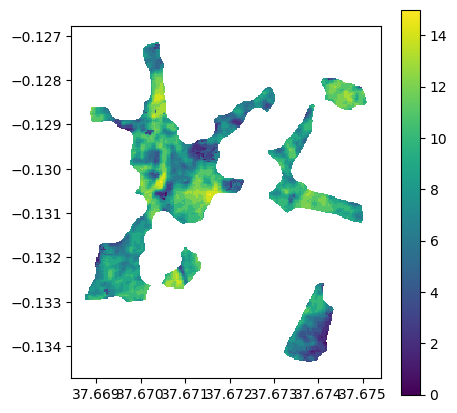

In [55]:
mask = df['date'] == df['date'].max()
most_recent = df[mask]

#Create a geodataframe that uses the pixel_boundary_geom column
gdf = gpd.GeoDataFrame(
    most_recent,
    geometry=gpd.GeoSeries.from_wkt(most_recent['pixel_boundary_geom'], crs='EPSG:4326'),
)

gdf.plot(column='canopy_height', cmap='viridis', legend=True, figsize=(5, 5))

## Look at Average Polygon Data over time

In [57]:
#Convert to a GeoDataFrame using the x and y coordinates to create point geometries

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], crs="EPSG:4326"))
gdf = gdf.set_crs(epsg=4326) # Set the coordinate reference system to WGS 84 (EPSG:4326)

# Drop rows with NaN values in the specified columns
gdf = gdf.dropna(subset=['aboveground_live_carbon_density', 'canopy_cover', 'canopy_height'])

#Simplify gdf to only the columns we want to plot
gdf = gdf[['date', 'aboveground_live_carbon_density', 'canopy_cover', 'canopy_height', 'geometry']]

## Label Planet Point data with the polygon id

In [58]:
#check that polygons and gdf are in the same CRS
print("Polygons CRS:", polygons.crs)
print("gdf CRS:", gdf.crs)

if polygons.crs == gdf.crs:
    print("polygons and gdf are in the same CRS.")
else:
    print("polygons and gdf are NOT in the same CRS.")

Polygons CRS: EPSG:4326
gdf CRS: EPSG:4326
polygons and gdf are in the same CRS.


In [59]:
# Perform spatial join to label each point in gdf with the polygon_id from polygons
gdf = gpd.sjoin(gdf, polygons[['polygon_id', 'geometry']], how='left', predicate='within')

# Drop the index_right column added by sjoin for clarity
gdf = gdf.drop(columns=['index_right'])

gdf.head(2)

,date,aboveground_live_carbon_density,canopy_cover,canopy_height,geometry,polygon_id
157441,2020-12-21,33.0,28.0,4.0,POINT (37.66989 -0.12909),0
157748,2020-12-21,35.0,32.0,6.0,POINT (37.67011 -0.12976),0


## Summarize the average value of each plot at each date

In [60]:
planet_timeline = (gdf.groupby(['polygon_id', 'date'], observed=True)
          .agg({'aboveground_live_carbon_density': 'mean',
                'canopy_cover': 'mean',
                'canopy_height': 'mean'
                })
         .rename(columns={
             'aboveground_live_carbon_density': 'planet_carbon_density_mean',
                'canopy_cover': 'planet_canopy_cover_mean',
                'canopy_height': 'planet_canopy_height_mean'
         })
        .reset_index()
        .sort_values(by=['polygon_id', 'date'])
    )
planet_timeline.head()

,polygon_id,date,planet_carbon_density_mean,planet_canopy_cover_mean,planet_canopy_height_mean
0,0,2020-12-21,44.939231,48.659925,8.499473
1,0,2021-03-21,44.886610,48.517013,8.478673
2,0,2021-06-21,44.872520,48.475415,8.470622
3,0,2021-09-21,44.864564,48.480207,8.466021
4,0,2021-12-21,44.836001,48.368542,8.457299


In [45]:
planet_metrics=['planet_canopy_height_mean', 'planet_carbon_density_mean', 'planet_canopy_cover_mean']

for metric in planet_metrics:

    fig = px.scatter(planet_timeline, x='date', y=metric, color='polygon_id', height=500, width=700,
                    title=metric) 
    fig = fig.update_traces(mode='lines+markers')
    fig.show()